In [1]:
using Distributions, Statistics, LinearAlgebra, StatsPlots
mu = [ 0; 0 ]
M2 = [1 -3; -1 1];
cov = [ 1 2 ; 2 3];
c = cov * cov / 100;
#c = I(2);
d = MvNormal(mu,c);
mc_reps = 1500;
sample_size = 100;
p = 2;
q = 1;
r = p-q;
#first dimension of errors is mc_reps and second dimension is sample
errors = [M2 + rand(d,p) for _ in 1:mc_reps, _ in 1:sample_size];
#makes a mc_reps by 1 matrix of matrices
matrix_estimates = mean(errors,dims=(2));
mapslices(eigvals,matrix_estimates,dims=())



demeaned_matrices = [errors[i,:,:] .- matrix_estimates[i,:,:] for i in 1:mc_reps]

cov_estimates = Array{Float64,3}(undef,mc_reps,p^2,p^2) 
smaller_cov_estimate = Array{Float64}(undef,p,p);
smaller_cov_estimates = Array{Float64,3}(undef,mc_reps,p,p)

for mcrep in 1:mc_reps
    cov_estimate = Array{Float64,2}(undef,p^2,p^2);
    fill!(cov_estimate,0.0);
    for s in 1:sample_size
        cov_estimate += vec(demeaned_matrices[mcrep][s])*vec(demeaned_matrices[mcrep][s])';
    end
    #average across other dimension
    fill!(smaller_cov_estimate,0.0)
    for maus in 1:p
        #1 p+1 2p+1 to p 2p 
        smaller_cov_estimate += cov_estimate[(1+ (maus-1)*p) : (maus*p) , (1+ (maus-1)*p) : (maus*p) ]
    end

    cov_estimates[mcrep,:,:] = cov_estimate / sample_size;
    smaller_cov_estimates[mcrep,:,:] = smaller_cov_estimate / (p*sample_size)
end


In [2]:
smaller_cov_estimates[1,:,:]

2×2 Matrix{Float64}:
 0.0565396  0.0895517
 0.0895517  0.143368

In [3]:
cov_estimates[1,:,:]

4×4 Matrix{Float64}:
 0.0541603   0.0860801  0.00516216  0.0073422
 0.0860801   0.13872    0.0105724   0.0153741
 0.00516216  0.0105724  0.0589189   0.0930233
 0.0073422   0.0153741  0.0930233   0.148017

In [4]:
c

2×2 Matrix{Float64}:
 0.05  0.08
 0.08  0.13

In [5]:
ch = cholesky(inv(c));
ch.L * transpose(ch.L) - inv(c)

2×2 Matrix{Float64}:
  0.0          -1.13687e-13
 -1.13687e-13   0.0

Now, we have made errors, find a matrix

In [6]:
ups = eigvecs(M2)[:,1];
upsperp = Array{Float64,1}(undef,2);
upsperp[1] = ups[2];
upsperp[2] = -ups[1];
dot(ups,upsperp);
dot(upsperp,eigvecs(M2)[:,2])

function Dhat(Mhat,q,element1,element2)
    p = size(Mhat,1);
    r=p-q;
    #make left part of test stat
    R = eigvecs(Mhat);
    ev = eigvals(Mhat);
    L = inv(R)';
    RI = R[:,1:q];
    D = R[1:r,1:q] * inv(R[(r+1):p,1:q]);
    return (D[element1,element2]);
end

function DInvSqrtCovMatEstimate(Mhat,OmegaW,q,element1,element2)
    p = size(Mhat,1);
    r=p-q;
    #make left part of test stat
    R = eigvecs(Mhat);
    ev = eigvals(Mhat);
    L = inv(R)';
    RI = R[:,1:q];
    RJ = R[:,(q+1):p];
    LI = L[:,1:q];
    LJ = L[:,(q+1):p];
    Lambda = Diagonal(eigvals(Mhat));
    LambdaI = Lambda[1:q,1:q];
    LambdaJ = Lambda[(q+1):p,(q+1):p];
    Jacobianinv = inv(kron(transpose(LambdaI),I(r)) - kron(I(q),LambdaJ));
    Ri2inv = inv(R[(r+1):p,1:q]);
    D = R[1:r,1:q] * Ri2inv;
    ups_perp = Array{Float64,2}(undef,p,r);
    ups_perp[1:r,1:r] = I(r);
    ups_perp[(r+1):p,1:r] = -D;
    BD = kron(Ri2inv,transpose(ups_perp)*RJ) * Jacobianinv * kron(transpose(RI),transpose(LJ));
    Omega = BD * kron(I(p),OmegaW) * BD';
    cf = cholesky(pinv(Omega));
    #ch = cholesky(inv(c));
    #ch.L * transpose(ch.L) - inv(c)
    return (ch.L[element1,element2]);
end


function tStat(Mhat,M0,OmegaW,q,element1,element2,samplesize)
    numerator = Dhat(Mhat,q,element1,element2) - Dhat(M0,q,element1,element2);
    inversecholeskiifactor = DInvSqrtCovMatEstimate(Mhat,OmegaW,q,element1,element2);
    return (numerator*inversecholeskiifactor);
end




tStat (generic function with 1 method)

Remember to set the sample size to one for Wald stats

In [7]:
reference = [randn() for _ in 1:mc_reps];
point_estimator = [Dhat(matrix_estimates[i],q,1,1) for i in 1:mc_reps];
t_statistic = [tStat(matrix_estimates[i],M2,smaller_cov_estimates[i,:,:],q,1,1,sample_size) for i in 1:mc_reps];

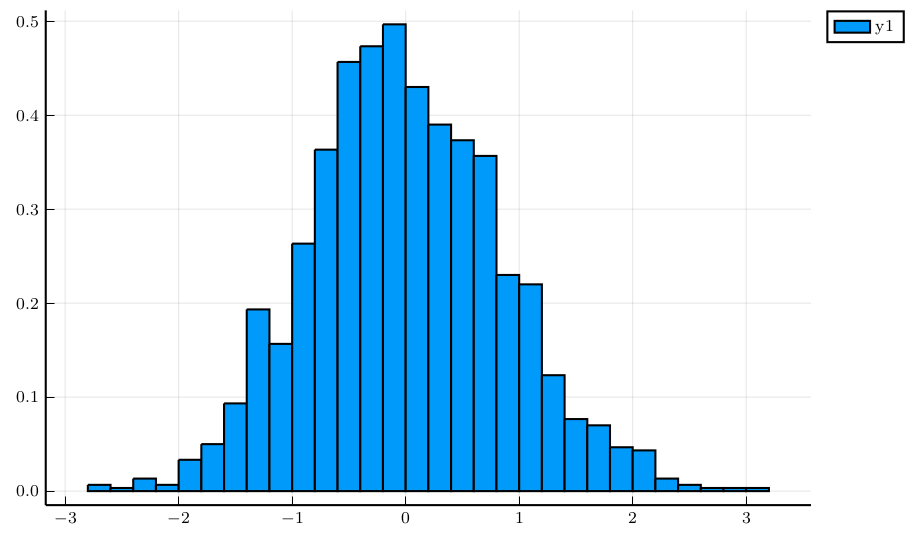

In [8]:
pgfplotsx()
histogram(t_statistic,normalize = :pdf)

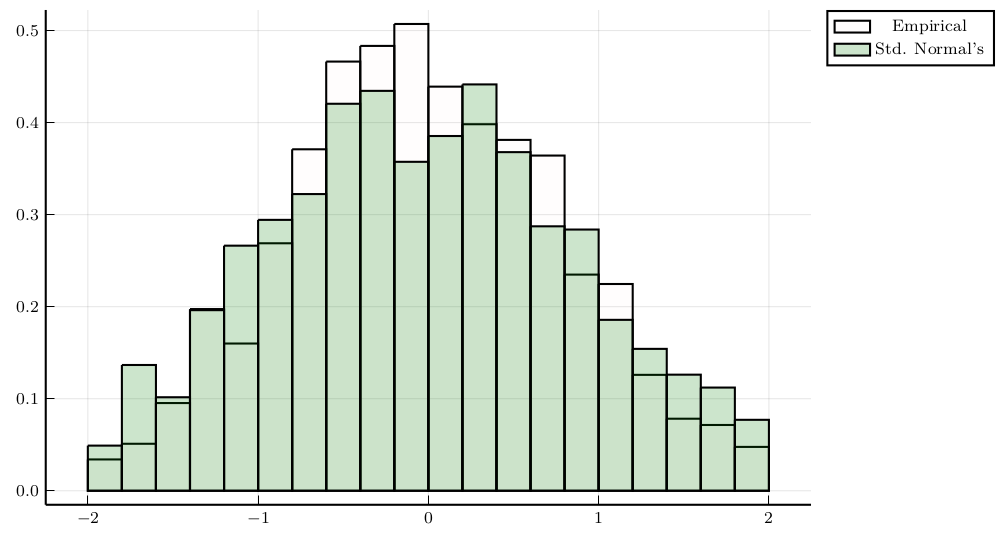

In [9]:
b_range = range(-2, 2, length=21)
histogram([t_statistic reference], label=["Empirical" "Std. Normal's"],bins=b_range,normalize = :pdf, color=[:red :green],fillalpha=[0.01 0.2])

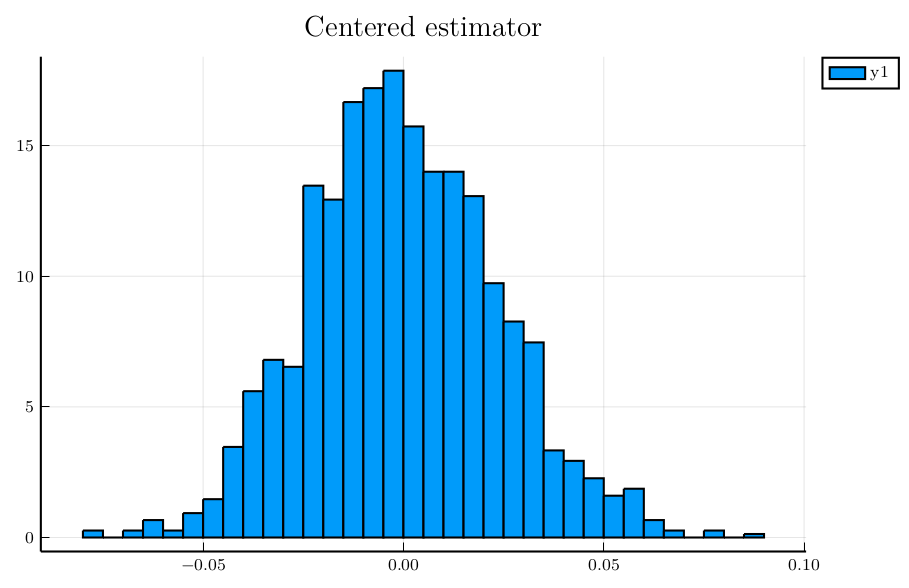

In [10]:
histogram(point_estimator.-Dhat(M2,q,1,1),normalize = :pdf,title="Centered estimator")

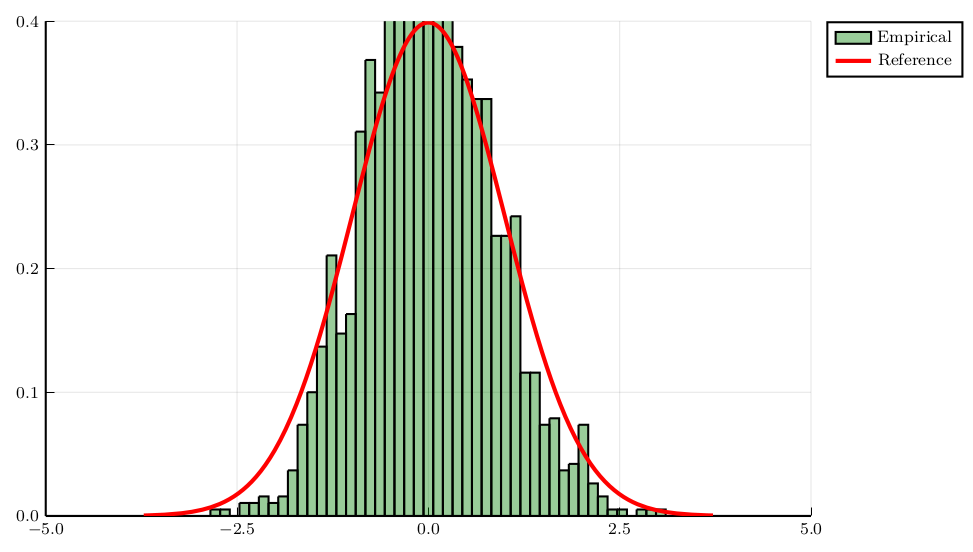

In [11]:
#histogram(t_statistic,normalize = :pdf)
dens(x) = 1/sqrt(2pi) * exp(-x^2/2)
b_range = range(-5, 5, length=80)

histogram(t_statistic, label="Empirical", bins=b_range, normalize=:pdf, color=:green,fillalpha=0.4)
plot!(Normal(0,1), label="Reference", lw=2, color=:red)
xlims!(-5, 5)
ylims!(0, 0.4)
#title!("Normal distribution, 1000 samples")
#xlabel!("x")
#ylabel!("P(x)")

In [12]:
png("t_statistic")
savefig("t_sta.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/t_sta.svg"

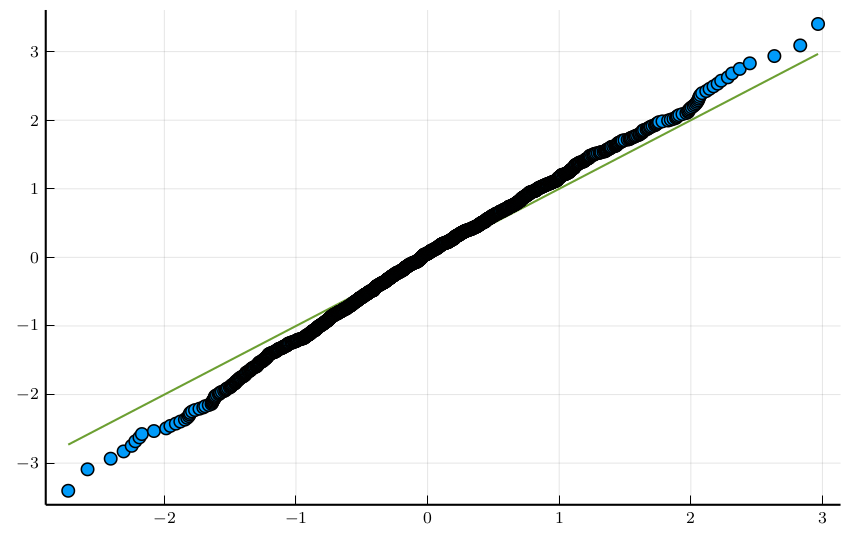

In [13]:
qqplot(t_statistic,Normal(0,1))

In [14]:
savefig("qqt.tex")
savefig("qqt.pdf")
savefig("qqt.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/qqt.svg"

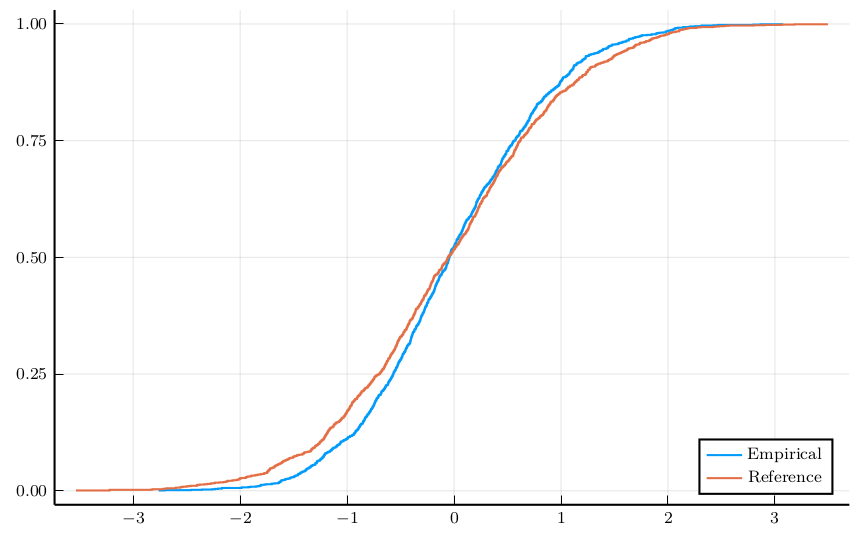

In [15]:
using StatsBase
scatter(ecdf(t_statistic),label="Empirical")
scatter!(ecdf(reference),label="Reference",legend=:bottomright)

In [16]:
png("cdft")
savefig("cdft.tex")
savefig("cdft.pdf")
savefig("cdft.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/cdft.svg"

In [17]:
rejections = abs.(t_statistic) .> quantile(Normal(0,1),.95);
mean(rejections)

0.048666666666666664